# example of earthquake time-forecasting CNN
Ong, Giani, Nielsen

Modified for multiple stations by Dewsnap

**mount Google Drive as a disk to access files and data**






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd "/content/drive/MyDrive/DISS_FOLDER/New_Data"

/content/drive/MyDrive/DISS_FOLDER/New_Data


In [ ]:
#cd  "/content/drive/MyDrive/DISS_FOLDER/Veda_Data"

In [ ]:
import pickle
import numpy as np

**set choice for input files (determines the type of normalisation)**

In [ ]:
choice = 'old' # old=norm on all 3 components together. new2=no norm. new=norm on individual components,

**set name of output model weights**

In [ ]:
# name of model weights file with version number of the training
tnum=2
WeightsFile='./model_'+str(tnum)+'.h5'
print('weights for the pending training will be saved in:',WeightsFile)

weights for the pending training will be saved in: ./model_2.h5


**read input files**

In [ ]:
print(choice)

def loadData():
  normnoise = pickle.load( open( "./Data/normnoise_"+choice+".p", "rb" ) )
  normpre = pickle.load( open( "./Data/normpre_"+choice+".p", "rb" ) )
  testlist = pickle.load( open( "./Data/testlist.p", "rb" ) )
  trainlist = pickle.load( open( "./Data/trainlist.p", "rb" ) )

  x_train = [normpre[i] for i in trainlist]
  x_test = [normpre[i] for i in testlist]
  x_noise_train = [normnoise[i] for i in trainlist]
  x_noise_test = [normnoise[i] for i in testlist]

  return [x_train,x_test,x_noise_train,x_noise_test]


old


In [ ]:
def processData():

  [x_train,x_test,x_noise_train,x_noise_test] = loadData()

  #print(x_train[0][0][0])

  window_length=16384
  L=len(x_train[0][0][0])
  #Make data into a format such that it can be concatenated
  x_train2 = np.reshape(x_train, (len(x_train)*len(x_train[0]), window_length, len(x_train[0][0][0])))

  x_test2 = np.reshape(x_test, (len(x_test)*len(x_test[0]), window_length, L))
  x_noise_train2 = np.expand_dims(x_noise_train, axis=-1)
  x_noise_test2 = np.expand_dims(x_noise_test, axis=-1)
  x_noise_train2 = np.reshape(x_noise_train2, (len(x_noise_train)*len(x_noise_train[0]), window_length, L))
  x_noise_test2 = np.reshape(x_noise_test2, (len(x_noise_test)*len(x_noise_test[0]), window_length, L))

  # Generate ground truth (ones = 'precursor' class, zeros = 'noise' class)
  y_train2 = np.ones(len(x_train2))
  y_test2 =np.ones(len(x_test2))
  y_noise_train2 = np.zeros(len(x_noise_train2))
  y_noise_test2 = np.zeros(len(x_noise_test2))
  y_train2  = y_train2.tolist()
  y_test2 = y_test2.tolist()
  y_noise_train2 = y_noise_train2.tolist()
  y_noise_test2 = y_noise_test2.tolist()

  #Concatenate noise and precursor datasets 
  x_train = np.append(x_train2,x_noise_train2, axis=0)
  x_test = np.append(x_test2,x_noise_test2, axis=0)
  y_train = np.append(y_train2,y_noise_train2, axis=0)
  y_test = np.append(y_test2,y_noise_test2, axis=0)


  print(x_train.shape)
  print(x_test.shape)
  print(y_train.shape)
  #print(x_train[0])
  #print(y_train[0])
  print(y_test.shape)
  print(L)

  return [x_train,x_test,y_train,y_test,L,window_length]

[x_train,x_test,y_train,y_test,L,window_length] = processData()


(2072, 16384, 9)
(518, 16384, 9)
(2072,)
(518,)
9


In [ ]:
!pip install pip install np_utils
#!pip install tensorflow==2.8

#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
import tensorflow as tf 
import numpy as np
import time
import os
from keras.models import Model
from keras.layers import Conv1D, BatchNormalization, Add, MaxPooling1D, Dropout, Dense, Flatten, CuDNNLSTM, ZeroPadding1D
from keras.layers import Activation, Input, concatenate, GaussianNoise, GlobalMaxPooling1D, GlobalAveragePooling1D, Softmax, Permute, Multiply, Masking
#from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.optimizers import Adam,RMSprop, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.regularizers import *  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**buid the CNN footprint**

In [ ]:
y_train2=y_train #for confusion matrix
y_test2=y_test
y_train= to_categorical(y_train, num_classes=2)
y_test= to_categorical(y_test, num_classes=2)



def encoder(input_shape, nb_classes):
    
    input_layer= Input(input_shape)
    random = Conv1D(L, 3, padding='same', kernel_initializer='random_normal')(input_layer) #NEED TO CHANGE 3->L??

    X = Add()([input_layer, random])

    conv3 = Conv1D(filters=32, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(X)
    conv3 = Conv1D(filters=32, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv3)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv4 = Conv1D(64, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv3)
    conv4 = Conv1D(64, kernel_size=7,padding='same', strides=1, kernel_initializer='random_normal')(conv4)        
    conv4 = MaxPooling1D(3, strides=2)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    conv5 = Conv1D(filters=64, kernel_size=5, padding='same', dilation_rate=2, kernel_initializer='random_normal')(conv4)
    conv5 = MaxPooling1D(3, strides=1)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
        
    conv3 = Conv1D(filters=128, kernel_size=5,padding='same', dilation_rate=4 , kernel_initializer='random_normal')(conv5)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv3 = Conv1D(filters=128, kernel_size=5,padding='same', dilation_rate=8 , kernel_initializer='random_normal')(conv3)
    conv3 = MaxPooling1D(3, strides=1)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv4 = Conv1D(256, kernel_size=3,padding='same',  dilation_rate=16 , kernel_initializer='random_normal')(conv3)
    conv4 = MaxPooling1D(3, strides=1)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    conv5 = Conv1D(filters=256, kernel_size=3, padding='same', dilation_rate=32, kernel_initializer='random_normal')(conv4)
    conv5 = MaxPooling1D(3, strides=1)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.02)(conv5)
  
    Y = GlobalAveragePooling1D()(conv5)
    Y = Dense(256, activation='relu', kernel_initializer='random_normal')(Y)
    Y = Dropout(0.02)(Y)

  
    output_layer = Dense(nb_classes, activation='softmax', kernel_initializer='random_normal')(Y)
    
    model = Model(inputs=input_layer, outputs=output_layer)

        
    return model      
    
model=encoder((window_length, L), 2)   #NEED TO CHANGE 3->L I THINK
model.compile(loss='binary_crossentropy', optimizer=RMSprop(0.0001), metrics=['accuracy'])
model.summary()  


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16384, 9)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16384, 9)     252         ['input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 16384, 9)     0           ['input_1[0][0]',                
                                                                  'conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 16384, 32)    2048        ['add[0][0]']                

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
#from matplotlib import pyplot as plt
#from keras.callbacks import TensorBoard
#from keras import backend as K


class My_Callback(Callback):

    def on_epoch_begin(self, epoch, logs={}):
        session = K.get_session()
        self.model.layers[1].kernel.initializer.run(session=session)
        return

    def on_epoch_end(self, epoch, logs={}):
        #layer_index = 0  ## index of the layer you want to change
        # random weights to reset the layer
        #new_weights = np.random.randn(*self.model.layers[layer_index].get_weights().shape)

        #self.model.layers[layer_index].set_weights(new_weights)

        return

callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath=WeightsFile, verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=False, mode='max'),
    My_Callback()]



**start training the cnn**

In [ ]:
#!%%pypy
# This callback reinitialises the weights in the first layer of the neural network (random layer in my report) at the start of each epoch.
class My_Callback(Callback):

    def on_epoch_begin(self, epoch, logs={}):
        # Code change to implement random layer in new version of TensorFlow
        # Get current weights
        weights = self.model.layers[1].get_weights()
        new_weights = []
        # Only the kernel is re-initialized, not the bais. For this reason I copy the old bais in the new weights.
        # I want the new weights to have the same distribution as the old ones. 
        # For this reason, I scale the normal distribution by the stddev and mean of the initializer of the layer.
        # To make sure that the right number of weights are generated, I use the shape of the old weights as a template.
        new_weights.append(self.model.layers[1].kernel_initializer.stddev * np.random.randn(*weights[0].shape) + self.model.layers[1].kernel_initializer.mean)
        
        new_weights.append(weights[1])
        self.model.layers[1].set_weights(new_weights)
        
        return

    def on_epoch_end(self, epoch, logs={}):

        return

# Changed val_acc into val_accuracy in monitor to fir with new version of TensorFlow

# Changed Early Stopping patience from 15 to 30
callbacks = [
    EarlyStopping(patience=100, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    #ModelCheckpoint('weights_nonorm.h5', verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=True),
    ModelCheckpoint(WeightsFile, verbose=1, save_best_only=True, monitor='val_accuracy', save_weights_only=True),

My_Callback()]

#model.fit(x_train, y_train, batch_size=16, epochs=100, shuffle=True, callbacks=callbacks,
#                    validation_data=(x_test, y_test))
CNNmodel = model.fit(x_train, y_train, batch_size=32, epochs=100, shuffle=True, callbacks=callbacks, validation_data=(x_test, y_test))

Epoch 1/100
 6/65 [=>............................] - ETA: 21s - loss: 0.6630 - accuracy: 0.6094

65/65 [==============================] - ETA: 0s - loss: 0.5509 - accuracy: 0.7138
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to ./model_2.h5
65/65 [==============================] - 45s 421ms/step - loss: 0.5509 - accuracy: 0.7138 - val_loss: 0.6997 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8692
Epoch 2: val_accuracy did not improve from 0.50000
65/65 [==============================] - 26s 393ms/step - loss: 0.3500 - accuracy: 0.8692 - val_loss: 1.0368 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9170
Epoch 3: val_accuracy did not improve from 0.50000
65/65 [==============================] - 26s 395ms/step - loss: 0.2177 - accuracy: 0.9170 - val_loss: 2.1450 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9445
E

**Loading the saved weights and only testing the network (no training) on both train and test datasets:**

In [ ]:
model.load_weights(WeightsFile)
Tr = model.evaluate(x_train, y_train, verbose=1)[-1]
Te = model.evaluate(x_test, y_test, verbose=1)[-1]

print('Train Accuracy: ', Tr)
print('Test Accuracy: ', Te)

17/17 [==============================] - 2s 111ms/step - loss: 1.1050 - accuracy: 0.7124
Train Accuracy:  0.9247104525566101
Test Accuracy:  0.7123551964759827


       loss  accuracy  val_loss  val_accuracy       lr
0  0.550894  0.713803  0.699685           0.5  0.00010
1  0.350032  0.869209  1.036832           0.5  0.00010
2  0.217706  0.916988  2.144975           0.5  0.00010
3  0.171807  0.944498  3.068205           0.5  0.00010
4  0.124425  0.970077  3.106777           0.5  0.00001


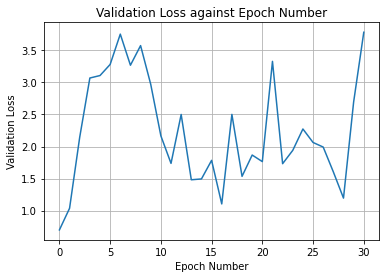

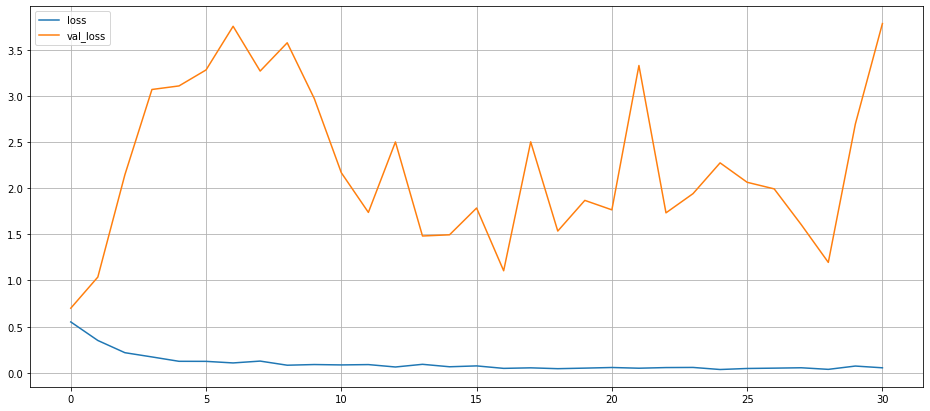

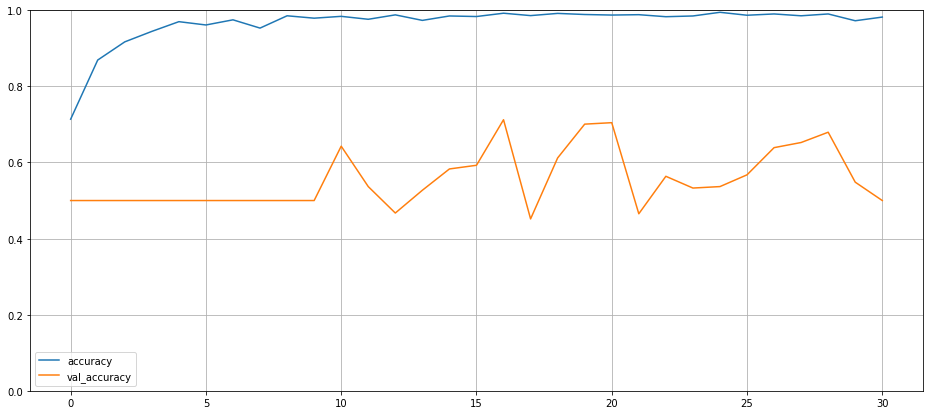

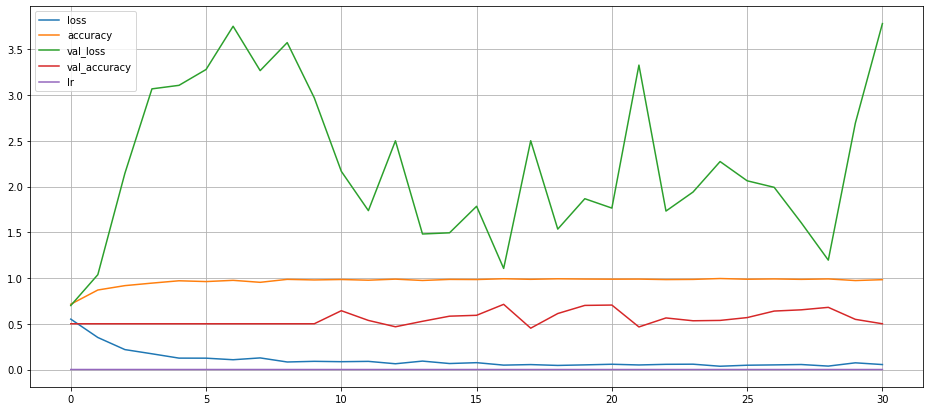

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dF = pd.DataFrame(CNNmodel.history)
print(dF.head())

dF[["val_accuracy"]].plot(xlabel="Epoch Number",ylabel="Validation Accuracy",title="Validation Loss against Epoch Number")
plt.legend().remove()
plt.grid()

dF[["loss","val_loss"]].plot(figsize=(16,7))
plt.grid()

dF[["accuracy","val_accuracy"]].plot(figsize=(16,7))
plt.grid()
plt.ylim([0,1])

dF.plot(figsize=(16,7))
plt.grid()

In [ ]:
pred=[0,0]
pred[0] = model.predict(x_train,verbose = 1)
pred[1] = model.predict(x_test,verbose = 1)

y = [y_train,y_test]

#print(type(y[0][0]))

C=[[[0,0],[0,0]],[[0,0],[0,0]]] # format: [[TP,TN],[FP,FN]]

for k in range(2):

  for i in range(len(pred[k])):
    #print(k)
    #print(round(y[k][i][1]))
    #print(round(pred[k][i][0]))

    C[k][round(y[k][i][1])][round(pred[k][i][1])]+=1

print(C[0])
print()
print(C[1])


17/17 [==============================] - 2s 110ms/step
[[901, 135], [21, 1015]]

[[111, 148], [1, 258]]




========================================================================

###3 Stations

========================================================================

OLD 3

    70/70 [==============================] - 8s 115ms/step - loss: 0.0749 - accuracy: 0.9653
    17/17 [==============================] - 2s 116ms/step - loss: 1.1534 - accuracy: 0.8185
    Train Accuracy:  0.9653153419494629
    Test Accuracy:  0.8185328245162964

NEW 3

    70/70 [==============================] - 8s 115ms/step - loss: 0.0210 - accuracy: 1.0000
    17/17 [==============================] - 2s 112ms/step - loss: 1.4550 - accuracy: 0.6351
    Train Accuracy:  1.0
    Test Accuracy:  0.6351351141929626

NEW2 3

    70/70 [==============================] - 8s 115ms/step - loss: 0.2356 - accuracy: 0.9113
    17/17 [==============================] - 2s 114ms/step - loss: 0.7836 - accuracy: 0.8571
    Train Accuracy:  0.911261260509491
    Test Accuracy:  0.8571428656578064